# NGC Machine Learning
 


Nama : Maulana Achsan 
Batch : RMT 

Tugas ini untuk menambah skill tentang ML dan Linear regression dengan data set yang diberikan mengenai asuransi dan faktor faktor yang menambah biaya asuransi perbulan


In [938]:
# Importing libraries yang dibutuhkan 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,r2_score
from feature_engine.outliers import Winsorizer

from scipy.stats import kendalltau, pearsonr

## Smart Problem Statement 

### Specific 
Membuat model machine learning yang bisa memprediksi charge/iuran asuransi per bulan. 

### Measurement 
Model dianggap berhasil ketika MAE mendekati angka 0 

### Achievable
Bermodalkan dataset yang sudah kita punya maka kita bisa membuat model machine learning berdasarkan dataset ini, didukung dengan team data kita yang siap untuk melakukan analisis serta pembuatan model tersebut

### Relevant
Pembuatan model memang harus presisi untuk memastikan prediksi iuran asuransi.Model itu akan kita deploy dalam website kita sehingga orang yang akan mengikuti program asuransi kita bisa membuat perkiraan sendiri di rumah tanpa harus menghubungi kita atau datang ke kantor kita. Namun ketika orang itu sudah datang ke kantor atau melakukan kontak kepada kita maka akan ada faktor faktor khusus yang membuat harga asuransi bisa naik dan turun tergantung kebutuhan pada setiap kasus. 


### Time Bound
Pengerjaan ini akan dilakukan dalam waktu 3 bulan.

### Problem Statement 

Membuat Model machine learning untuk memprediksi charge asuransi per bulan dengan ukuran MAE mendekati 0 didukung oleh kepemilikan team data dan dataset, model ini akan kita buat untuk kemudahan customer dan pegawai kita. Customer bisa memberi perkiraan berapa harga yang akan dia bayar per bulan tanpa harus contact kita atau datang ke kantor kita. pegawai kita bisa fokus ke hal lain selain memperkirakan harga asuransi dan menemui pelanggan. Pengerjaan ini akan dilakukan dalam waktu 3 bulan. 

## Data Loading

In [939]:
df = pd.read_csv(r"C:\Users\asanm\Hacktiv8\fase2\W1\Senin\lat_sendiri_senin\insurance.csv")
df.sample(10)

,age,sex,bmi,children,smoker,region,charges
461,42,male,30.000,0,yes,southwest,22144.03200
539,53,male,31.350,0,no,southeast,27346.04207
208,63,female,31.800,0,no,southwest,13880.94900
950,57,male,18.335,0,no,northeast,11534.87265
103,61,female,29.920,3,yes,southeast,30942.19180
532,59,male,29.700,2,no,southeast,12925.88600
704,47,female,29.545,1,no,northwest,8930.93455
97,55,male,38.280,0,no,southeast,10226.28420
1094,50,female,33.700,4,no,southwest,11299.34300
1192,58,female,32.395,1,no,northeast,13019.16105


Dari data ini terlihat berisi 7 kolom dan berisi kolom contoh seperti umur kelamin dan BMI (body mass index). Dari sample ini cukup bersih dan tidak ada duplikasi sepertinya namun perlu di gali lebih dalam karena hanya sampel dari 10 data. Belum mereferensikan seluruh data

In [940]:
# pembuatan copy untuk memastikan data mempunyai duplikatnya
df2 = df.copy()

In [941]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Data terdiri dari 7 kolom dan 4 type data numerik dan type data kategorik. dilihat dari data type nya seperti nya sudah okay semua. Ambil contoh untuk age sudah berada pada datatype integer dan sex pada datatype object. 

In [942]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Pada kolom usia memiliki rata-rata 39 tahun dan deviasi 19 namun range nya sekitar 46. Asuransi hanya bisa diambil oleh orang-orang yang memiliki usia 18 tahun ke atas. terlihat di data minimum.  
pada kolom bmi rata-rata 30 dan std 6 dekat dengan titik tengah (median) sekitar 30 berarti kemungkinan ini normal dan 68% data terpusat di titik 30 +- std. 
rata rata customer memiliki anak 1 
untuk kolom charges range nya yaitu 62 ribuan dan rata2 itu 13200 an namun ini kita tidak diberi tahu apakah ini range per tahun apa per month. kita asumsikan disini per bulan saja. 

In [943]:
df.duplicated().sum()

1

In [944]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [945]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Exploratory data analysis 

Membuat rumus untuk melihat bentuk datanya kira kira seperti apa sehingga kita bisa tau gambaran data semua secara sekilas. Ini cenderung memakai boxplot bisa pakai histogram dsb

In [946]:
def plot_all_boxplots(df):
    """
    Membuat boxplot untuk setiap kolom numerik dalam DataFrame."""
    # Pilih hanya kolom numerik
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Tentukan ukuran figure
    plt.figure(figsize=(5, 5))
    
    # Loop melalui setiap kolom numerik dan buat boxplot
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(1,len(numeric_cols), i)
        plt.boxplot(df[col].dropna(), vert=True)
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
    
    # Sesuaikan layout agar tidak tumpang tindih
    plt.tight_layout()
    
    # Tampilkan plot
    plt.show()

# Contoh penggunaan:
# df = pd.read_csv('your_data.csv')
# plot_all_boxplots(df)


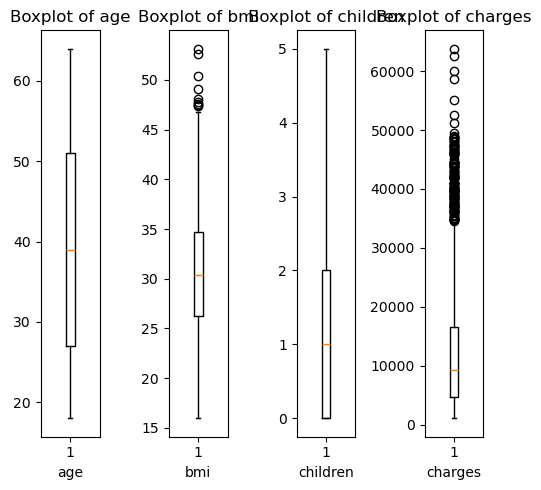

In [947]:
plot_all_boxplots(df)

Untuk data age dan children tidak ada outliernya. namun pada data bmi dan charges masih terdapat outlier yang mana penentuan untuk handling atau tidak harus kita lihat nanti. 
terlihat juga pada charges itu menghitam bulatannyha itu menandakan data banyak sekali outlier di titik2 itu 

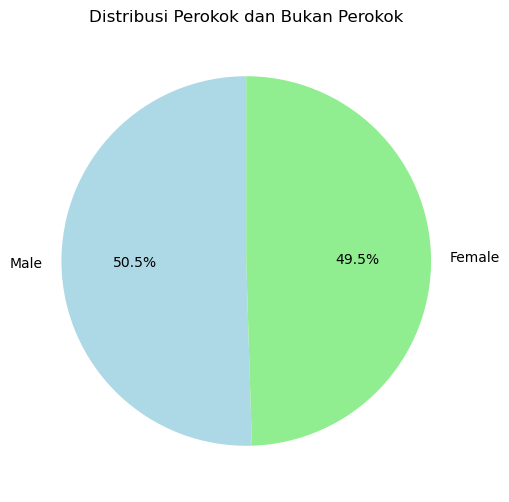

In [948]:
jumlah_cowok= len(df[df['sex']=='male'])
jumlah_cewek= len(df[df['sex']=='female'])

# Data untuk pie chart
labels = ['Male', 'Female']
values = [jumlah_cowok, jumlah_cewek]
colors = ['lightblue', 'lightgreen']

# Membuat pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

# Menambahkan judul
plt.title('Distribusi Perokok dan Bukan Perokok')

# Menampilkan plot
plt.show()

Data terbagi 2 hampir sama besar antara jumlah konsumen asuransi cowok dan cewek. Jadi kita ke depannya masih bisa menyeimbangkan kecenderungan produk kita untuk kedua jenis kelamin ini, tanpa harus condong ke salah satu jenis kelamin. 

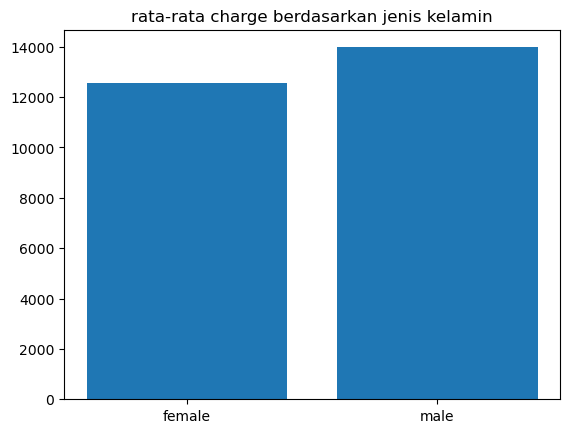

In [949]:
list_rata_kelamin =[]
kelamin= df['sex'].unique()
for i in kelamin : 
    rata_kelamin = df[df['sex']== i]['charges'].mean()
    list_rata_kelamin.append(rata_kelamin)

plt.bar(x = kelamin, height=list_rata_kelamin)
plt.title('rata-rata charge berdasarkan jenis kelamin')
plt.show()

rata-rata charge untuk cowok jauh lebih besar. harus kita ketahui dulu ini mengapa dan faktor penyebabnya

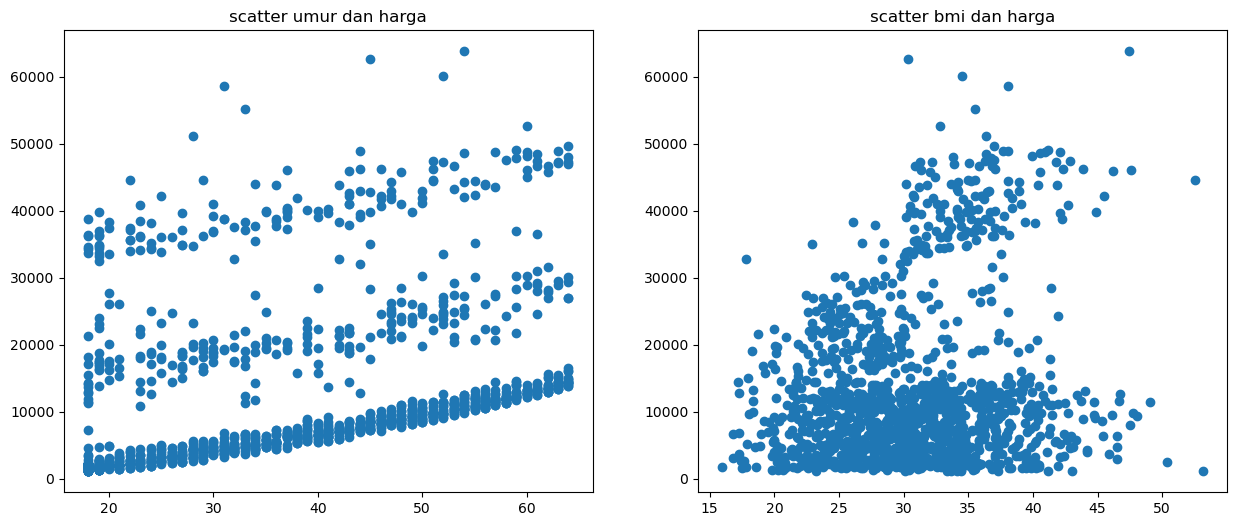

In [950]:
plt.figure (figsize= (15,6))
plt.subplot(1,2,1)
plt.scatter (x= df['age'], y= df['charges'])
plt.title ('scatter umur dan harga')


plt.subplot(1,2,2)
plt.scatter(x= df['bmi'], y = df['charges'])
plt.title ('scatter bmi dan harga')

plt.show()

ada kecenderungan korelasi postif pada haraga dan umur. semakin umur tinggi maka harga juga akan naik. ini seperti resiko terjadinya penyakit. semakin tua seseorang maka kemungkinan orang tersebut mendapatkan penyakit semakin tinggi. Namun korelasi ini terbagi menjadi 3 bagian yaitu bagian ke 1 bagian ke 2 dan bagian ke 3 jika kita tarik garis regresinya. jadi data ini menunjukkan ada perbedaan harga asuransi pada umur tinggi dan rendah. Namun korelasinya masih terbagi lagi menjadi 3. 

pada scatter bmi dan harga ini menunjukkan randomnya data, data ini cenderung tidak berkorelasi antara bmi dan harga. meskipun ada indikasi positif namun titik dibawah cenderung banyak. 

### Menjawab Soal 

1. Overweight kelas 1 30<= BMI < 35
2. Overweight kelas 2 35<= BMI < 40 
3. Overweight kelas 3 BMI >= 40 
4. Tidak OW  BMI <30

In [951]:
# Eda Non 


OW1 = df[(df['bmi'] < 35 ) & (df['bmi'] >= 30 )]   
print('jumlah ow 1 ' ,len(OW1))

OW2 = df[(df['bmi'] < 40 ) & (df['bmi'] >= 35 )]   
print('jumlah ow 2 ' ,len(OW2))

OW3 = df[(df['bmi'] >= 40 )]   
print('jumlah ow 3 ' ,len(OW3))

NON_OW = df [df['bmi']< 30]

print('non overweight ', len(NON_OW))

jumlah ow 1  390
jumlah ow 2  225
jumlah ow 3  91
non overweight  631


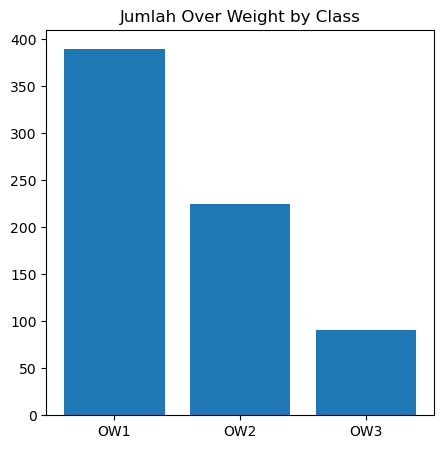

In [952]:
namaX= ['OW1','OW2','OW3']
namaY = [len(OW1),len(OW2),len(OW3) ]

plt.figure (figsize=(5,5))
plt.bar(x=namaX, height= namaY)
plt.title('Jumlah Over Weight by Class')

plt.show()

Data overweight per class menunjukkan bahwa OW 1 berada di angka terbanyak yaitu ketika BMI 30 sampai 35 disusul oleh OW kelas 2 dan OW kelas 3. perlu diketahui orang orang over weight ini merupakan orang2 yang ada ancaman terhadap kesehatannya terutama penyakit metabolik. meskipun faktor lain masih ada yang mendukung namun ini adalah salah satu skala yang biasanya dipakai orang untuk menentukan apakah mereka baik secara kesehatan atau tidak. dalam konteks asuransi ya. 

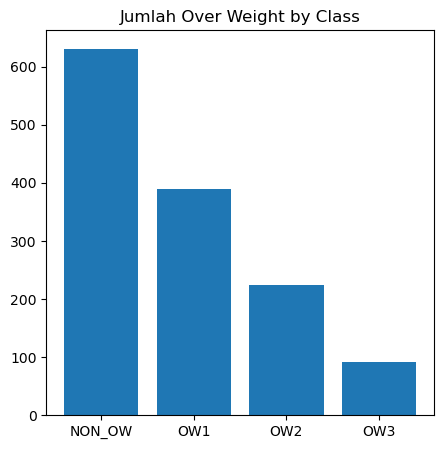

In [953]:
namaX= ['NON_OW','OW1','OW2','OW3']
namaY = [len(NON_OW),len(OW1),len(OW2),len(OW3) ]
persentase = []

plt.figure (figsize=(5,5))
plt.bar(x=namaX, height= namaY)
plt.title('Jumlah Over Weight by Class')
plt.show()

Untuk memperjelas kita lihat jumlah perbandingan antara OW dan normal pada data. Normal terlihat mendominasi jauh dibandingkan Overweight. Ini perlu kita lihat lagi secara persentase 

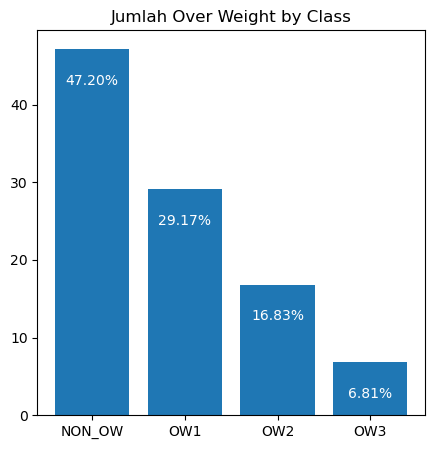

In [954]:
namaX= ['NON_OW','OW1','OW2','OW3']
namaY = [len(NON_OW),len(OW1),len(OW2),len(OW3) ]
total= sum(namaY)
persentase =[(jumlah / total) * 100 for jumlah in namaY]

plt.figure (figsize=(5,5))
bars = plt.bar(x=namaX, height=persentase)
plt.title('Jumlah Over Weight by Class')
for bar, percentage in zip(bars, persentase):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 5, f'{percentage:.2f}%', ha='center', va='bottom', color='white')
plt.show()


47% pelanggan asuransi kita merupakan orang yang memiliki badan normal. Dan disusul oleh OW 1, dan seterusnya hingga OW kelas 3. Kita akan melihat hubungan antara kelas ow ini per kelas untuk menentukan apakah kelas ini memiliki korelasi dengan harga 

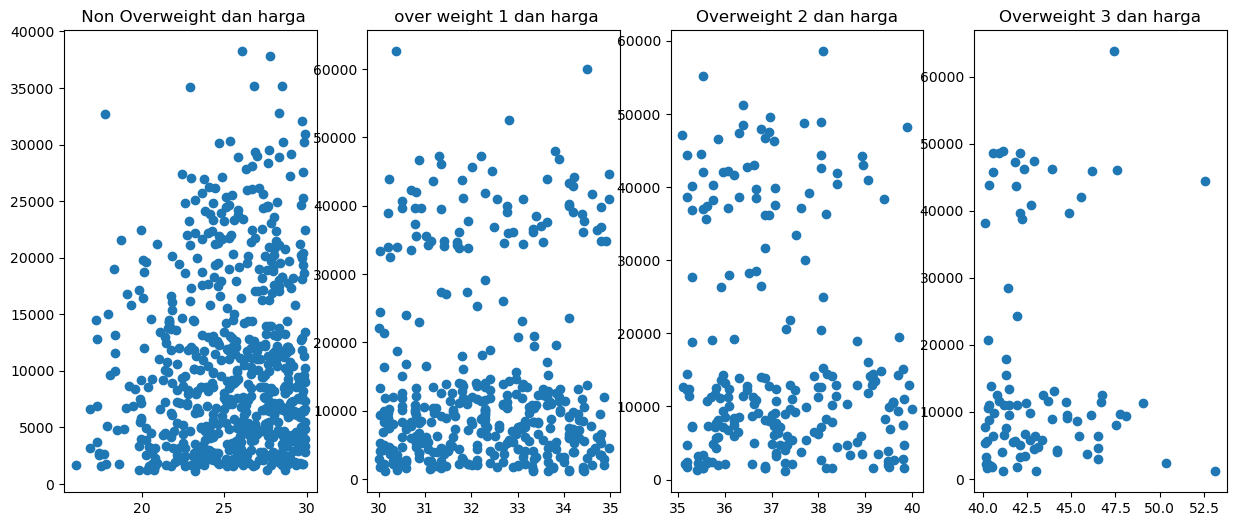

In [955]:
plt.figure(figsize= (15,6))

plt.subplot (1,4,1)
plt.scatter (x= NON_OW['bmi'], y= NON_OW['charges'])
plt.title (' Non Overweight dan harga')

plt.subplot (1,4,2)
plt.scatter (x= OW1['bmi'], y= OW1['charges'])
plt.title (' over weight 1 dan harga')

plt.subplot (1,4,3)
plt.scatter (x= OW2['bmi'], y= OW2['charges'])
plt.title ('Overweight 2 dan harga')

plt.subplot (1,4,4)
plt.scatter (x= OW3['bmi'], y= OW3['charges'])
plt.title ('Overweight 3 dan harga')

plt.show()

tidak ada korelasi positif antara harga dan kelas weight pada kelas yang telah kita tentukan. Kita beri contoh pada harga 2000 maka setiap data menunjukkan ada saja orang yang terkena charge 2000 perbulan untuk biaya iuran asuransinya. 

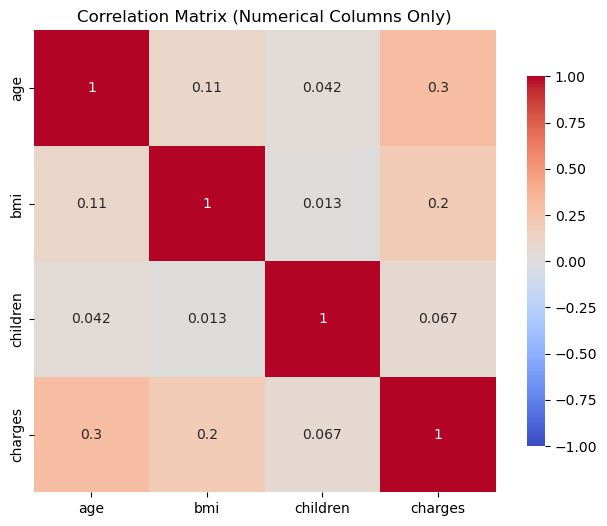

In [956]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Hitung matriks korelasi pada kolom yang bertipe numerik
correlation_matrix = numeric_df.corr()

# Buat diagram korelasi menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix (Numerical Columns Only)')
plt.show()

Tidak ada korelasi tinggi antara age bmi dan children terhadap iuran per bulan. Untuk contoh kita lihat baris charges. Kita pertemukan baris charges dengan kolom children. maka kita ketemu korelasi antara kepemilikan anak dan charges adalah 6% angka ini sangat kecil dan bisa diabaikan dalam konteks korelasi. Karena tidak menggambarkan korelasi yang tinggi. Korelasi yang tinggi adalakh korelasi yang mempunyai angka 0,5 ke atas. angka korelasi itu 1 sampai -1. Jika korelasi di atas 0,5 atau dibawah -0,5 maka korelasi itu moderat kuat. 

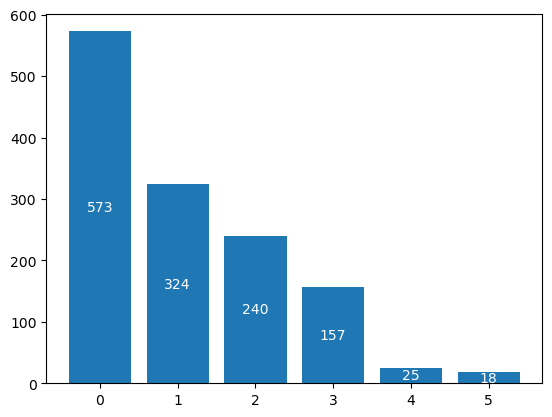

In [957]:
jumlah_anak= df['children'].value_counts()

bars = plt.bar(x= jumlah_anak.index , height=jumlah_anak.values)
for bar in bars:
    yval = bar.get_height()  # Mendapatkan tinggi setiap batang
    plt.text(bar.get_x() + bar.get_width()/2, yval / 2, f'{yval}', ha='center', va='center', color='white')  # Menempatkan teks di tengah bar

plt.show()



In [958]:
sort_anak = sorted(df['children'].unique())

mayoritas pelanggan kita adalah customer dengan tidak memiliki anak

rata rata charge untuk pelanggan yang memiliki anak 0 adalah 12384.69534422164
rata rata charge untuk pelanggan yang memiliki anak 1 adalah 12731.171831635802
rata rata charge untuk pelanggan yang memiliki anak 2 adalah 15073.563733958332
rata rata charge untuk pelanggan yang memiliki anak 3 adalah 15355.318366815285
rata rata charge untuk pelanggan yang memiliki anak 4 adalah 13850.6563112
rata rata charge untuk pelanggan yang memiliki anak 5 adalah 8786.035247222222


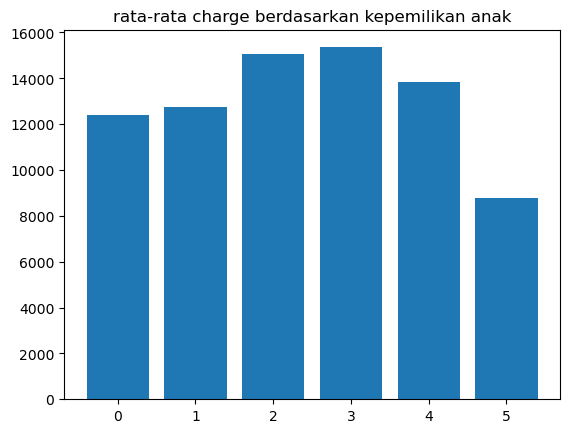

In [959]:
list_rata_anak =[]
for i in sort_anak : 
    rata_charge = df[df['children']== i]['charges'].mean()
    print(f'rata rata charge untuk pelanggan yang memiliki anak {i} adalah {rata_charge}')
    list_rata_anak.append(rata_charge)

plt.bar(x = sort_anak, height=list_rata_anak)
plt.title('rata-rata charge berdasarkan kepemilikan anak')
plt.show()

memang terlihat ada kenaikan charge ketika kita bandingkan kepemilikan anak 3 dan tidak mempunyai anak. namun data ini menjadi tidak relevan ketika kepemilikan anak itu 4 malah turun dan kepemilikan anak 5 malah terlihat lebih turun lagi. jadi kepemilikan anak tidak bisa menjadi patokan apakah asuransi kita akan semakin mahal atau tidak. 

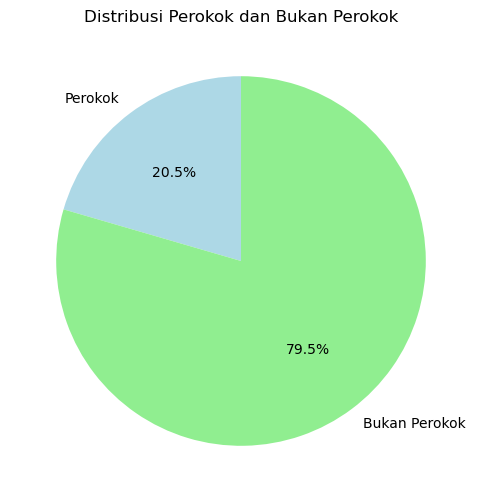

In [960]:
jumlah_perokok = len(df[df["smoker"] == "yes"])
jumlah_non_perokok = len(df[df["smoker"] == "no"])

# Data untuk pie chart
labels = ['Perokok', 'Bukan Perokok']
values = [jumlah_perokok, jumlah_non_perokok]
colors = ['lightblue', 'lightgreen']

# Membuat pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

# Menambahkan judul
plt.title('Distribusi Perokok dan Bukan Perokok')

# Menampilkan plot
plt.show()


jumlah konsumen kita banyak yang perokok. 80% konsumen kita merupakan perokok. namun kita harus mengetahui apakah rata2 charge untuk perokok dan bukan perokok berbeda ? 

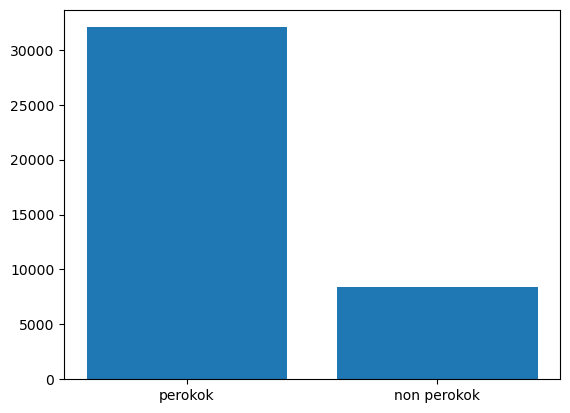

In [961]:
rata_perokok= df[df["smoker"] == "yes"]['charges'].mean()
rata_non_perokok = df[df["smoker"] == "no"]['charges'].mean()

plt.bar (x=['perokok','non perokok'], height= [rata_perokok,rata_non_perokok])
plt.show()

Terlihat orang orang yang merokok mempunyai rata-rata charge asuransi yang jauh lebih tinggi. perbedaan 20.000 dolar menujukkan angka yang tinggi untuk perbeddaan asuransinya. hal ini senada dengan temuan saya pada website penyedia asuransi di amerika. https://parinsurance.com/how-smoking-affects-your-health-insurance-premiums/ disini dijelaskan ternyata memang perokok itu ada kelas-kelasnya dan bisa kita simpulkan bahwa ketika kita tidak merokok maka asuransi kita bisa lebih rendah charge nya. 

In [962]:
rata_rata_charges = df.groupby(['sex', 'smoker'])['charges'].mean().unstack()

# Pastikan hasil dari unstack benar
print(rata_rata_charges)



smoker           no           yes
sex                              
female  8762.297300  30678.996276
male    8099.700161  33042.005975


ada perbedaan antara cowok dan cewe perokok dan chargenya maka untuk memperbaiki model kita lebih baik tidak drop kolom sex


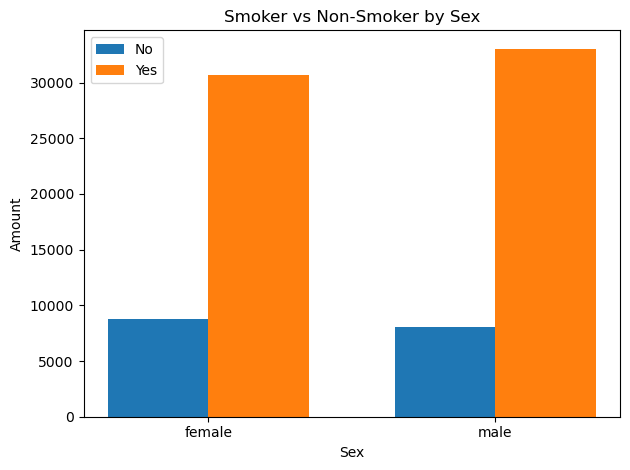

In [963]:


# Data dari tabel
categories = ['female', 'male']
smoker_no = [8762.297300, 8087.204731]
smoker_yes = [30678.996276, 33042.005975]

# Lebar bar
bar_width = 0.35
index = np.arange(len(categories))

# Membuat plot
fig, ax = plt.subplots()

# Menambahkan bar
bar1 = ax.bar(index, smoker_no, bar_width, label='No')
bar2 = ax.bar(index + bar_width, smoker_yes, bar_width, label='Yes')

# Menambahkan label dan judul
ax.set_xlabel('Sex')
ax.set_ylabel('Amount')
ax.set_title('Smoker vs Non-Smoker by Sex')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()


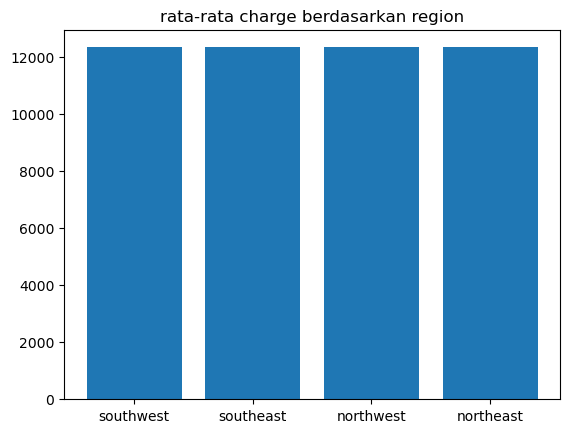

In [964]:
list_region = df['region'].unique()
rata_region = []

for i in list_region : 
    rata_region_ini= df[df['region']== list_region[0]]['charges'].mean() 
    rata_region.append(rata_region_ini)

plt.bar(x = list_region, height=rata_region)
plt.title('rata-rata charge berdasarkan region')
plt.show()

Meskipun pada website https://parinsurance.com/how-smoking-affects-your-health-insurance-premiums/ menunjukkan bahwa region di USA bisa menjadi faktor charge asuransi.  namun kenyataannya dalam data ini faktor region tidak menunjukkan perbedaan charges asuransi. karena rata-rata charge asuransi pada setiap region menunjukkan angka yang sama. Karena data benar benar sama maka kita bisa drop data ini pada feature engineering. 

## Feature Engineering 

Kita telah selesai melakukan EDA dan ada beberapa kesimpulan seperti OW 1 lebih banyak dibandingkan kelas OW lainnya. ada korelasi antara harga dan umur. Umur terlihat sudah terdistribusi normal. Bmi dan harga sepertinya tidak berkorelasi berdasarkan scatter plot. 

disini kita akan menentukan feature feature mana yang akan kita pakai dan fiture mana yang akan kita tidak pakai dan bisa kita drop. 

kita akan menggunakan target yaitu price yang mana ( model akan menentukan berapa harga asuransi nya ketika seseorang datang ke kantor asuransi dan memberikan fitur fitur maka model akan bisa memprediksi berapa harga asuransi berdasarkan model yang telah kita lati ) 

In [965]:
pd.set_option('display.max_colwidth', None)

cat_cols = list(df.select_dtypes(include='object').columns)

listItem = []
for col in cat_cols:
  listItem.append([col, df[col].nunique(), df[col].unique()])

pd.DataFrame(columns=['nama kolom', 'jumlah nilai unique', 'nilai unique'], data=listItem)

,nama kolom,jumlah nilai unique,nilai unique
0,sex,2,"[female, male]"
1,smoker,2,"[yes, no]"
2,region,4,"[southwest, southeast, northwest, northeast]"


Dilihat dari tabel di atas kita bisa tahu bahwa kolom kategorikal pada data kita itu memiliki nilai uniquie kurang dari sama dengan 4. Dengan mengetahui ini kita tidak perlu handling kolom dengan high cardinality karena nilai 4 ini tidak memiliki kardinal yang tinggi. 

### Split antara target dan fitur 


In [966]:
#splitting antara train dan 
X= df.drop(['charges'], axis = 1 )
y = df['charges']

Ini kita lakukan sehingga kita tau mana yang akan kita prediksi dan mana faktor faktor yang mempengaruhi prediksi. charges merupakan prediksi jadi kita gunain charges untuk prediksi. karena kita ingin tahu berapa charges kita per bulan. 

In [967]:
# split antara test dan training data 
# penggunaan test size 20% 
X_train, X_test, y_train , y_test = train_test_split(X,y, test_size= 0.2, random_state = 15)

print('Train Size', X_train.shape)
print('Test Size', X_test.shape)

Train Size (1069, 6)
Test Size (268, 6)


transformasi fitur dilakukan jika kita ingin mempermudah dataset untuk mempelajari pola. Menurut saya, dari proses EDA, data yang bisa diklasifikasikan yaitu pada BMI. namun setelah melihat pada hubungan antara BMI dan prices pada setiap body mass index (pemisahan OW 1 dan OW 2 dan 3 serta normal) itu tidak ada korelasi. maka kita bisa skip proses ini. kita tidak perlu melakukan fitur creation.

### Handling Outlier

Setelah melakukan pemisahan dan tidak ada penambahan fitur selanjutnya kita handling outlier. 

In [968]:
#check distribution form skewness
num_cols = list(X_train.select_dtypes(exclude='object').columns)

listItem= []

for col in num_cols:
  listItem.append([col, round(X_train[col].skew(),1), np.where(
    (round(X_train[col].skew(),1) <= 0.5) & (round(X_train[col].skew(),1) >= -0.5),
    'normal',
    'skewed')])



skewness = pd.DataFrame(columns=['nama kolom', 'nilai skewness', 'distribution'], data= listItem)
skewness

,nama kolom,nilai skewness,distribution
0,age,0.0,normal
1,bmi,0.3,normal
2,children,1.0,skewed


distribusi data numerik menunjukkan ada distribusi tidak normal yaitu pada kolom children dan nilai lain yaitu normal distribution. Ini untuk menentukan kita handling dengan tukey atau dengan normal z score rule.
normal memakai z score dengan 3 kali std 
distribusi tak normal memakai . = tukey 

In [969]:
# Get upper, lower boundaries and percentage of outliers

column = []
lower_bound = []
upper_bound = []
percent_total_outlier = []

for row in range (0, len(skewness)):
  col = skewness['nama kolom'][row]
  #checking upper and lower boundary
  if skewness['distribution'][row] == 'skewed':
    IQR = X_train[col].quantile(0.75) - X_train[col].quantile(0.25)
    lower_boundary = X_train[col].quantile(0.25) - (IQR * 3)
    upper_boundary = X_train[col].quantile(0.75) + (IQR * 3)
  else:
    lower_boundary = X_train[col].mean() - 3* X_train[col].std()
    upper_boundary = X_train[col].mean() + 3* X_train[col].std()
  #append to list
  column.append(col)
  lower_bound.append(lower_boundary)
  upper_bound.append(upper_boundary)
  totout = ((len(X_train[X_train[col] > upper_boundary]) / len(X_train) * 100) + (len(X_train[X_train[col] < lower_boundary]) / len(X_train) * 100))
  percent_total_outlier.append(totout)

outliers = pd.DataFrame({
    'column': column,
    #round the value
    'upper_boundary': [round(upper_bound,2) for upper_bound in upper_bound],
    'lower_boundary': [round(lower_bound,2) for lower_bound in lower_bound],
    'percentage_total_outlier': [round(percent_total_outlier,2) for percent_total_outlier in percent_total_outlier]
})
outliers

,column,upper_boundary,lower_boundary,percentage_total_outlier
0,age,81.37,-2.47,0.00
1,bmi,48.80,12.55,0.19
2,children,8.00,-6.00,0.00


Percentage outlier hanya ada pada BMI. Bisa dibilang Outlier ini merupakan orang orang dengan BMI yang sangat-tinggi karena Berdasarkan data dari rumah sakit siloam [source](https://www.siloamhospitals.com/informasi-siloam/artikel/)  cara-menghitung-bmi orang yang memiliki BMI kurang dari 18 saja sudah dibilang under weight. Bagaimana dengan orang-orang dengan BMI rendah dibawah 12 itu sangat tidak mungkin karena orang itu merupakan orang dengan malnutrisi asumsi saya. kemungkinan lain adanya outlier yaitu orang orang yang memiliki BMI di atas upper boundary. karena secara logika tidak mungkin orang yang malnutrisi atau berat badan kurang kemudian daftar asuransi. karena orang itu sudah sakit kok ada asuransi yang mau menerimanya. jadi jika saran saya sebagai agen asuransi maka lebih baik ditolak saja jika menemukan potensi pasien dengan BMI dibawah standard (malnutrisi). 

Untuk BMI di atas 50 mungkin orang itu memang obesitas ekstrem namun masih sehat. Kita bisa charge tinggi, kita bisa edukasi sehingga orang itu bisa berbadan normal. Win-win solution, orang itu dapat asuransi kita dan menjadi kurus karena kita edukasi dan kita dapat premi asuransi mahal setiap bulan. Meskipun ada indikasi bahwa nantinya orang ini bisa sakit ketika masih berasuransi dengan kita namun dengan premi tinggi diharapkan bisa menutupi itu. Perlu di adakan riset ulang opportunity cost sseperti apa dan profit tetap kita dapatkan.

dengan outlier seperti ini harusnya bisa trimming dan censoring. namun saya ingin menggunakan pendekatan Winsorizer di data ini karena saya ingin mempelajarinya. jika di kasus lain mungkin akan cenderung menggunakan trimming karena persentage outlier sangat kecil dan bisa diabaikan. Winsorizer disini supaya senada dengan pendapat saya siapa tau ada yang mau daftar asuransi ketika OW ekstrem.

In [970]:
# untuk pengecekan outlier pada bmi apakah titik maksimal sudah berubah
X_train['bmi'].max()

53.13

In [971]:
# penggunaan winsorizer untuk mengganti outlier dengan penggunaan batas terakhir dari sebaran data tertinggi atau terendah

winsoriser_bmi = Winsorizer(capping_method='gaussian',
                            tail='right',
                            fold=3,
                            variables=['bmi'],
                            missing_values='ignore')

X_train_capped = winsoriser_bmi.fit_transform(X_train)
X_test_capped = winsoriser_bmi.transform(X_test)

data sudah diganti dan kita cek dibawahnya 

In [972]:
X_train_capped['bmi'].max()

48.79458623167849

titik tertinggi sudah menjadi 3 kali std


### Split Between Numeric Columns and Categorical Columns

In [973]:
# Get numeric and categorical column 
#numeric
num_columns = X_train_capped.select_dtypes(include= np.number).columns.tolist()
#categoric
cat_columns = X_train_capped.select_dtypes(include=['object']).columns.tolist()

print(f' numerik kolom {num_columns}')
print(f' kolom kategori {cat_columns}')


 numerik kolom ['age', 'bmi', 'children']
 kolom kategori ['sex', 'smoker', 'region']


In [974]:
# pemisahan antara kategori dan non kategori
X_train_num = X_train_capped[num_columns]
X_test_num  = X_test_capped[num_columns]

X_train_cat = X_train_capped[cat_columns]
X_test_cat  = X_test_capped[cat_columns]

X_train_num.head()

,age,bmi,children
1134,28,33.820,0
715,60,28.900,0
15,19,24.600,1
58,53,22.880,1
972,22,20.235,0


### Feature Selection 

In [975]:
X_train_cat

,sex,smoker,region
1134,male,no,northwest
715,male,no,southwest
15,male,no,southwest
58,female,yes,southeast
972,female,no,northwest
...,...,...,...
1224,male,no,northeast
668,male,yes,northeast
156,male,yes,southeast
384,male,no,northeast


Setelah melakukan EDA di atas kita tahu bahwa ternyata rata2 premi per region tidak ada maka kita sisihkan region dan kita tidak pakai fitur itu. 

In [976]:
X_train_cat.drop(['region'], axis = 1 , inplace = True)
X_test_cat.drop(['region'], axis = 1, inplace= True) 
X_train_cat

C:\Users\asanm\AppData\Local\Temp\ipykernel_20356\397194895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cat.drop(['region'], axis = 1 , inplace = True)
C:\Users\asanm\AppData\Local\Temp\ipykernel_20356\397194895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_cat.drop(['region'], axis = 1, inplace= True)


,sex,smoker
1134,male,no
715,male,no
15,male,no
58,female,yes
972,female,no
...,...,...
1224,male,no
668,male,yes
156,male,yes
384,male,no


### Correlation using kendall and pearson

#### kendal tau first

In [978]:
# Feature selection Numerical columns
p_values = []
interpretasi = []
cols = []

for col in X_train_cat.columns:
  corr_coef, p_value = kendalltau(X_train_cat[col], y_train)

  p_values.append(p_value)
  cols.append(col)

  if p_value < 0.05:
    interpretasi.append('ada korelasi')
  else :
    interpretasi.append('ga ada korelasi')

pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi})

,nama kolom,hasil
0,sex,ga ada korelasi
1,smoker,ada korelasi


Ternyata kolom sex dan kolom target tak ada korelasi maka kita bisa drop itu

In [979]:
X_train_cat.drop(['sex'], axis = 1 , inplace = True)
X_test_cat.drop(['sex'], axis = 1, inplace= True) 
X_train_cat

C:\Users\asanm\AppData\Local\Temp\ipykernel_20356\2824198284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cat.drop(['sex'], axis = 1 , inplace = True)
C:\Users\asanm\AppData\Local\Temp\ipykernel_20356\2824198284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_cat.drop(['sex'], axis = 1, inplace= True)


,smoker
1134,no
715,no
15,no
58,yes
972,no
...,...
1224,no
668,yes
156,yes
384,no


Cek sudah terhapus dari kelompok categorical

In [980]:
# Feature selection Numerical columns
p_values = []
interpretasi = []
cols = []

for col in X_train_num.columns:
  corr_coef, p_value = pearsonr(X_train_num[col], y_train)

  p_values.append(p_value)
  cols.append(col)

  if p_value < 0.05:
    interpretasi.append('ada korelasi')
  else :
    interpretasi.append('ga ada korelasi')

pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi})

,nama kolom,hasil
0,age,ada korelasi
1,bmi,ada korelasi
2,children,ada korelasi


Semua mempunyai korelasi jadi kita pertahankan 

In [992]:
#Scaling menggunakan minmaxscaler
scaler = MinMaxScaler()
scaler.fit(X_train_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_train_num_scaled

array([[0.2173913 , 0.54393863, 0.        ],
       [0.91304348, 0.39409664, 0.        ],
       [0.02173913, 0.26313717, 0.2       ],
       ...,
       [0.65217391, 0.25765514, 0.        ],
       [0.56521739, 0.18806389, 0.4       ],
       [0.45652174, 0.31247539, 0.2       ]])

Sudah terlihat sudah menjadi kode kode yang memudahkan mesin untuk membaca. 

In [993]:
# melihat bentukan category grup
X_train_cat.head(10)

,smoker
1134,no
715,no
15,no
58,yes
972,no
497,no
1155,no
159,no
1159,no
806,no


Kita kode no sebagai 0 dan yes sebagai 1 menggunakan Ordinal Encoder

In [994]:
# Using Ordinal Encoder
encoder = OrdinalEncoder(categories= [['no','yes']])

encoder.fit(X_train_cat)

X_train_cat_encoded = encoder.transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)
X_train_cat_encoded

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]])

Menggabungkan 2 data categri dan data numeric setelah di scaling

In [997]:
X_train_final = np.concatenate([X_train_num_scaled,X_train_cat_encoded], axis = 1)
X_test_final = np.concatenate([X_test_num_scaled,X_test_cat_encoded], axis = 1)

X_train_final

array([[0.2173913 , 0.54393863, 0.        , 0.        ],
       [0.91304348, 0.39409664, 0.        , 0.        ],
       [0.02173913, 0.26313717, 0.2       , 0.        ],
       ...,
       [0.65217391, 0.25765514, 0.        , 1.        ],
       [0.56521739, 0.18806389, 0.4       , 0.        ],
       [0.45652174, 0.31247539, 0.2       , 0.        ]])

In [985]:
model_lin_reg = LinearRegression() 

In [986]:
model_lin_reg.fit(X_train_final,y_train)

LinearRegression()

In [987]:
y_pred_train = model_lin_reg.predict(X_train_final)

y_pred_test = model_lin_reg.predict(X_test_final) 

y_pred_train 

array([ 6308.65904376, 12499.45905348,  1477.59875563, ...,
       31741.09238273,  7266.60710255,  6930.72552516])

In [988]:
print ('Error - Train set : ' , mean_absolute_error(y_train,y_pred_train))

Error - Train set :  4298.182786632639


In [989]:
print ('Error Test' , mean_absolute_error(y_test,y_pred_test))

Error Test 4008.02698982164


MAE pada saat test kita mendapatkan 4800, yang artinya rata-rata eror kalu tidak kelebihan 4000 ya kurang dari 4000

In [990]:
print ('RMSE Test' , root_mean_squared_error(y_test,y_pred_test))

RMSE Test 5549.060030182621


RMSE 5567.

In [991]:
print ('R square Test' , r2_score(y_test,y_pred_test))

R square Test 0.7910627817294293


rsquare sebesar 79% ini menunjukkan model bisa memprediksi dengan baik sebesar 79% namun, sisa 21% nya model belum bisa memprediksi dengan baik mungkin. 

## Kesimpulan 

Model cukup baik dengan 77% mampu menebak dengan baik. namun model perlu dievaluasi lagi ke depannya. Untuk sekarang model bisa di deploy namun harus ada orang dibelakang layar untuk selalu mengecek apakah ini sudah benar atau belum karena masih ada potensi 23 % kesalaha yang dilakukan model. Ke depannya model ini perlu dievaluasi dengan penambahan atau pengurangan fiur yang lebih lanjut.